In [32]:
import glob

import numpy as np
import h5py

from pyproj import Transformer

import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## ATL14

In [149]:
# Setup
atl14 = '/att/nobackup/dfelikso/ICESat-2/ATL14/GL/ATL15_GL_0311_40km_001_01.nc'

atl14_epoch = datetime.datetime(2018,1,1,0,0,0)



In [154]:
h5file = h5py.File(atl14, 'r')

x_atl14 = h5file['delta_h']['x'][:]
y_atl14 = h5file['delta_h']['y'][:]
delta_h = h5file['delta_h']['delta_h'][:,:,:]

t_atl14 = h5file['delta_h']['time'][:]
t_atl14_utc = [atl14_epoch + datetime.timedelta(days=t) for t in t_atl14]

h5file.close()


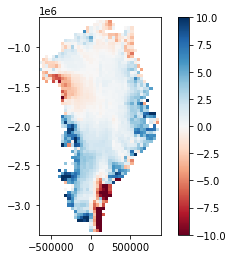

In [140]:
x_step = x_atl14[1] - x_atl14[0]
y_step = y_atl14[1] - y_atl14[0]
delta_h_extent = np.array([x_atl14[0]-x_step/2, x_atl14[-1]+x_step/2, y_atl14[0]-y_step/2, y_atl14[-1]+y_step/2])

delta_h[delta_h == float(np.finfo(np.float32).max)] = np.nan

plt.imshow(np.sum(delta_h, axis=0), extent=delta_h_extent, origin='lower', cmap='RdBu', vmin=-10, vmax=+10)
plt.colorbar()


## ATL11

In [160]:
atl11_granule = 'ATL11_007903_0311_004_01.h5'

transformer = Transformer.from_crs(4326, 3413)


In [161]:
h5file = h5py.File(atl11_granule, 'r')

atlas_sdp_gps_epoch = h5file['ancillary_data']['atlas_sdp_gps_epoch'][0]
gps_epoch = datetime.datetime(1980,1,6,0,0,0) # GPS epoch start date/time
atlas_epoch = gps_epoch + datetime.timedelta(seconds=atlas_sdp_gps_epoch) # ATLAS epoch start date/time in GPS time

lats_atl11 = dict()
lons_atl11 = dict()
xs_atl11 = dict()
ys_atl11 = dict()

h_corrs_atl11 = dict()
gps_seconds = dict()

for pt in ['pt1', 'pt2', 'pt3']:
    lats_atl11[pt] = h5file[pt]['latitude'][:]
    lons_atl11[pt] = h5file[pt]['longitude'][:]

    xs_atl11[pt], ys_atl11[pt] = transformer.transform(lats_atl11[pt], lons_atl11[pt])

    h_corrs_atl11[pt] = h5file[pt]['h_corr'][:,:]
    h_corrs_atl11[pt][h_corrs_atl11[pt] == float(np.finfo(np.float32).max)] = np.nan

    gps_seconds[pt] = atlas_sdp_gps_epoch + h5file[pt]['delta_time'][:]
    gps_seconds[pt][gps_seconds[pt] == float(np.finfo(np.float64).max)] = np.nan
    
h5file.close()

/home/dfelikso/.conda/envs/icesat2-test/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5, 1.0, 'dh(t)')

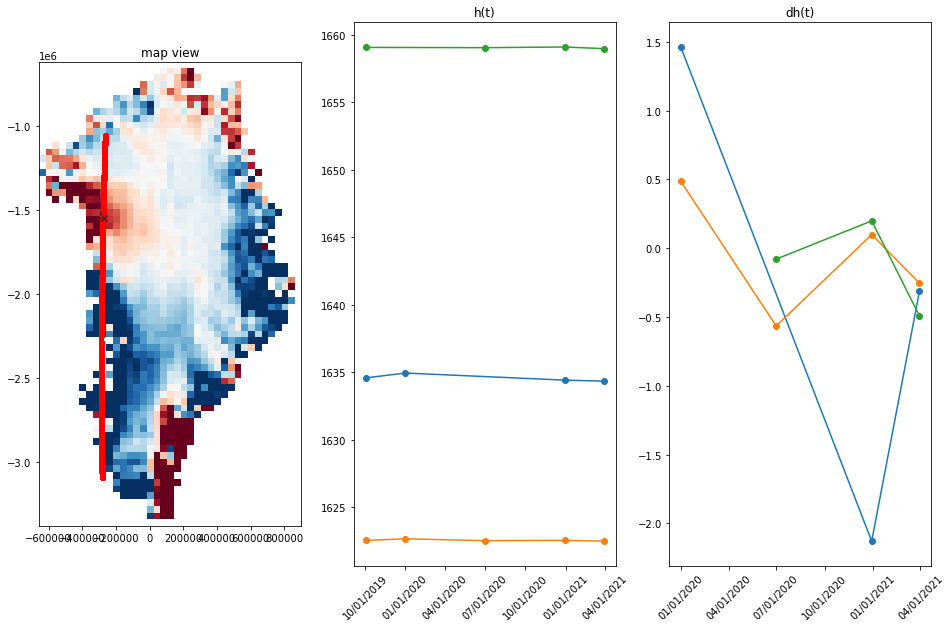

In [177]:
idx = 25000

fig, ax = plt.subplots(1,3,figsize=(16,10))

ax[0].imshow(np.sum(delta_h, axis=0), extent=delta_h_extent, origin='lower', cmap='RdBu', vmin=-4, vmax=+4)

for iax in [1,2]:
    ax[iax].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    ax[iax].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
for pt in ['pt1', 'pt2', 'pt3']:
    ax[0].plot(xs_atl11[pt],      ys_atl11[pt],      'r.')
    ax[0].plot(xs_atl11[pt][idx], ys_atl11[pt][idx], 'kx')
    
    t_utc = np.array([datetime.datetime(1980,1,6) + relativedelta(seconds=sec) \
             if not np.isnan(sec) else datetime.datetime(1980,1,6) for sec in gps_seconds[pt][idx,:]])
    h_corrs = h_corrs_atl11[pt][idx]
    
    t_utc = t_utc[~np.isnan(h_corrs)]
    h_corrs = h_corrs[~np.isnan(h_corrs)]

    ax[1].plot(t_utc, h_corrs, 'o-')
    
    dt_utc_days = np.array(len(t_utc))
    for i in range(1,len(t_utc)):
        dt_utc_days = (t_utc[i] - t_utc[i-1]).days
    
    ax[2].plot(t_utc[1:], np.diff(h_corrs) / (dt_utc_days/365.25), 'o-')
    
for iax in [1,2]:
    ax[iax].xaxis.set_tick_params(rotation=45)
#_ = ax[1].set_xticks([datetime.datetime(2019,1,1), datetime.datetime(2020,1,1)])
  
ax[0].set_title('map view')
ax[1].set_title('h(t)')
ax[2].set_title('dh(t)')


## Sample ATL14 at ATL11 location

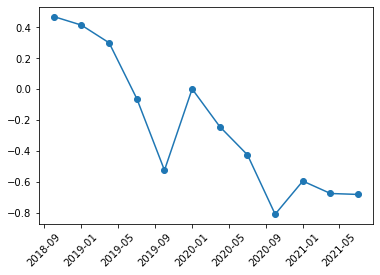

In [182]:
fig, ax = plt.subplots(1,1)

for pt in ['pt1', 'pt2', 'pt3']:
    x_atl11 = xs_atl11[pt][idx]
    y_atl11 = ys_atl11[pt][idx]
    
    x_atl11_p = ((x_atl11 - delta_h_extent[0]) / x_step).astype(int)
    y_atl11_p = ((y_atl11 - delta_h_extent[2]) / y_step).astype(int)
    
plt.plot(t_atl14_utc, delta_h[:, y_atl11_p, x_atl11_p], 'o-')
#plt.imshow(np.sum(delta_h, axis=0))
#plt.plot(x_atl11_p, y_atl11_p, 'kx')

ax.xaxis.set_tick_params(rotation=45)
